# Preamble
**Name:** Deborah Djon</br>
**Student Number:** 22261972</br>
**Module Code:** CA694</br>
**Module Name:** Practicum</br>
**Supervisor:** Dr. Geoff Hamilton</br>

## **Plagiarism Policy**
I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. I have read and understood the Assignment Regulations. I have identified and included the source of all facts, ideas, opinions, and viewpoints of others in the assignment references. Direct quotations from books, journal articles, internet sources, module text, or any other source whatsoever are acknowledged and the source cited are identified in the assignment references. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.</br>

I have read and understood the referencing guidelines found at
http://www.dcu.ie/info/regulations/plagiarism.shtml,
https://www4.dcu.ie/students/az/plagiarism and/or recommended in the assignment
guidelines.

# CNN With Collected Data

This Notebook implements the Paper [Fingerprinting Technique for YouTube Videos Identification in Network Traffic](https://ieeexplore.ieee.org/document/9832901). 

Their approach:
![T](./../../Images/afandiFingerprintingTechniqueYouTube2022-model_approach.png)

Model architecture: 
![X](./../../Images/afandiFingerprintingTechniqueYouTube2022-model_architecture.png)

## Imports

In [39]:
import sys
sys.path.append("../..")

import tensorflow as tf

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from modelling_utilities import data_processing
from modelling_utilities.constants import *
from modelling_utilities.visualisation import *
import json

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, MeanAbsoluteError
from tensorflow.keras.losses import CategoricalCrossentropy

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [40]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [42]:
vid_map_fp = DATA_FOLDER+"Metadata/all_ids_title_pseudonym_ids.json"
with open (vid_map_fp, "r") as f:
    vname_2_vid_map = json.load(f)
vname_2_vid_map
vid_2_vname_map = {v:k for k,v in vname_2_vid_map.items()}
vid_2_vname_map

{'3IosA_ir06Y': 'Video 1',
 'bhpTZOqXRN0': 'Video 2',
 'agTMr9qITlI': 'Video 3',
 'sFEYQMrWNHU': 'Video 4',
 'KUXS5fJPFSA': 'Video 5',
 'BuwLLUzp7DI': 'Video 6',
 'xYcHxF_cO8o': 'Video 7',
 'ZI9Fjo8k618': 'Video 8',
 'beHTyPTJzlQ': 'Video 9',
 'JZ1ZoR0Y4SU': 'Video 10',
 'WAfJpyBgcgA': 'Video 11',
 'aQDXXSh1psg': 'Video 12',
 'cicNiSBsDGI': 'Video 13',
 'xF_lJGizHOY': 'Video 14',
 'WwAkT9Wk9Gk': 'Video 15',
 'wqGLislwe2M': 'Video 16',
 'ECnC3Meyff4': 'Video 17',
 'buVYv-3f2Kc': 'Video 18',
 'b7v5XDJrH5g': 'Video 19',
 'RvrSoAzXVsE': 'Video 20',
 'tmlMwjkShLE': 'Video 21',
 'sQn_tYguBIY': 'Video 22',
 'i8UNGbSHv6U': 'Video 23',
 '3rzyq9SH3Qw': 'Video 24',
 'EMm_34CoDRo': 'Video 25',
 'xLKoTS90pvQ': 'Video 26',
 '2IFYt20QON8': 'Video 27',
 '9A_YXyZb9VE': 'Video 28',
 'c5gRjiHdnLk': 'Video 29',
 'ABBHqDKHqoY': 'Video 30',
 'yxAm9uRuItI': 'Video 31',
 '0mm05SkR_Ys': 'Video 32',
 'sIGVmChnbI8': 'Video 33',
 '7GGzc3x9WJU': 'Video 34',
 'k1Do5KcJLYQ': 'Video 35',
 'fATegRW2EE4': 'Video 36',
 

In [43]:
fp_feature = "adf_sparse"
fn = DATA_FOLDER + "Processed_Data/data-ms-aggregates/data-480-ms-aggregate.parquet"
data = data_processing.read_parquet_to_pandas(fn)
data = data[data["cw"]==1]
data["video_id"] = data["video_id"].map(vid_2_vname_map)
data.head()

,ts,bpts,video_id,cw,class,ts_i,bpi,ts_f,bpi_sparse,df,df_sparse,mpdf,mpdf_sparse,sdf,sdf_sparse,ndf,ndf_sparse,adf,adf_sparse
0,"[2023-06-22T11:47:33.180000, 2023-06-22T11:47:...","[0.0, 0.0, 5861.0, 5861.0, 5890.0, 72784.0, 11...",Video 1,1,3IosA_ir06Y,"[2023-06-22T11:47:43.490000, 2023-06-22T11:47:...","[90396.0, 36768.0, 1893990.0, 20191.0, 2796948...","[2023-06-22T11:47:43.490000, 2023-06-22T11:47:...","[90396.0, 36768.0, 1893990.0, 20191.0, 0.0, 0....","[-0.593256338776052, 50.511912532637076, -0.98...","[-0.593256338776052, 50.511912532637076, -0.98...","[-0.593256338776052, 0.9805870147149668, -0.98...","[-0.593256338776052, 0.9805870147149668, -0.98...","[-53628.0, 1857222.0, -1873799.0, 2776757.0, -...","[-53628.0, 1857222.0, -1873799.0, 2776757.0, 0...","[-0.4217231291875059, 0.9619134039584454, -0.9...","[-0.4217231291875059, 0.9619134039584454, -0.9...","[53628.0, 1857222.0, 1873799.0, 2776757.0, 239...","[53628.0, 1857222.0, 1873799.0, 2776757.0, 0.0..."
1,"[2023-06-22T10:59:57.390000, 2023-06-22T10:59:...","[5861.0, 5861.0, 5932.0, 72784.0, 25446.0, 567...",Video 1,1,3IosA_ir06Y,"[2023-06-22T10:59:57.390000, 2023-06-22T10:59:...","[90438.0, 1838239.0, 107716.0, 2789912.0, 2557...","[2023-06-22T10:59:57.390000, 2023-06-22T10:59:...","[90438.0, 1838239.0, 107716.0, 0.0, 0.0, 0.0, ...","[19.32595811495168, -0.94140261413233, 24.9006...","[19.32595811495168, -0.94140261413233, 24.9006...","[0.9508018271835164, -0.94140261413233, 0.9613...","[0.9508018271835164, -0.94140261413233, 0.9613...","[1747801.0, -1730523.0, 2682196.0, -232805.0, ...","[1747801.0, -1730523.0, 2682196.0, 0.0, 0.0, 0...","[0.9062175781636842, -0.8892924039867315, 0.92...","[0.9062175781636842, -0.8892924039867315, 0.92...","[1747801.0, 1730523.0, 2682196.0, 232805.0, 25...","[1747801.0, 1730523.0, 2682196.0, 0.0, 0.0, 0...."
2,"[2023-06-22T11:42:14.490000, 2023-06-22T11:42:...","[0.0, 5861.0, 5664.0, 5861.0, 72784.0, 11322.0...",Video 1,1,3IosA_ir06Y,"[2023-06-22T11:42:25.130000, 2023-06-22T11:42:...","[101492.0, 52273.0, 1887504.0, 2797031.0, 2557...","[2023-06-22T11:42:25.130000, 2023-06-22T11:42:...","[101492.0, 52273.0, 1887504.0, 0.0, 0.0, 0.0, ...","[-0.48495447917077206, 35.10858378130201, 0.48...","[-0.48495447917077206, 35.10858378130201, 0.48...","[-0.48495447917077206, 0.9723057540540312, 0.3...","[-0.48495447917077206, 0.9723057540540312, 0.3...","[-49219.0, 1835231.0, 909527.0, -239924.0, -25...","[-49219.0, 1835231.0, 909527.0, 0.0, 0.0, 0.0,...","[-0.3200923487139466, 0.9461041140296024, 0.19...","[-0.3200923487139466, 0.9461041140296024, 0.19...","[49219.0, 1835231.0, 909527.0, 239924.0, 25555...","[49219.0, 1835231.0, 909527.0, 0.0, 0.0, 0.0, ..."
3,"[2023-06-22T12:14:02.060000, 2023-06-22T12:14:...","[0.0, 5861.0, 5861.0, 72784.0, 6067.0, 25446.0...",Video 1,1,3IosA_ir06Y,"[2023-06-22T12:14:12.380000, 2023-06-22T12:14:...","[90573.0, 1920993.0, 20189.0, 2796149.0, 25571...","[2023-06-22T12:14:12.380000, 2023-06-22T12:14:...","[90573.0, 1920993.0, 20189.0, 0.0, 0.0, 0.0, 0...","[20.209333907455864, -0.9894903313026128, 137....","[20.209333907455864, -0.9894903313026128, 137....","[0.9528509474006412, -0.9894903313026128, 0.99...","[0.9528509474006412, -0.9894903313026128, 0.99...","[1830420.0, -1900804.0, 2775960.0, -239042.0, ...","[1830420.0, -1900804.0, 2775960.0, 0.0, 0.0, 0...","[0.9099477720343255, -0.9791992713717724, 0.98...","[0.9099477720343255, -0.9791992713717724, 0.98...","[1830420.0, 1900804.0, 2775960.0, 239042.0, 25...","[1830420.0, 1900804.0, 2775960.0, 0.0, 0.0, 0...."
4,"[2023-06-22T12:03:27.860000, 2023-06-22T12:03:...","[0.0, 5861.0, 5861.0, 7479.0, 7392.0, 26827.0,...",Video 1,1,3IosA_ir06Y,"[2023-06-22T12:03:38.540000, 2023-06-22T12:03:...","[84652.0, 1873710.0, 86811.0, 2796821.0, 25571...","[2023-06-22T12:03:38.540000, 2023-06-22T12:03:...","[84652.0, 1873710.0, 86811.0, 0.0, 0.0, 0.0, 0...","[21.134267353399803, -0.9536689242198633, 31.2...","[21.134267353399803, -0.9536689242198633, 31.2...","[0.95482

## Data Transfotmation

In [44]:
video_ids = list(data["video_id"].unique())
print("Number of videos", len(video_ids))

Number of videos 50


In [45]:
from typing import List
def show_traces(traces: List[List[float]] or List[float], traces_names:List[str] or str = None, title:str="" , trace_unit:Literal["MB", "B", "KB", "GB"] = None, x_label="", y_label="", unify_y_ranges:bool =False) -> None:
    """
    Visualise a set of bpp traces as a set of barplots. 
    @param traces: list of traces
    @param title: title of the plt
    @param TODO
    """

    trace_unit_factors = {
        "B":  1, 
        "KB": 1000, 
        "MB": 1000000, 
        "GB": 1000000000,
        "original":1
    }

    # Only one trace to visualise
    if (type(traces[0]) == float) or (type(traces[0]) == int):
        if(traces_names and (type(traces_names)==str)):
            title = title +"\n"+traces_names
        else:
            plt.title(title)
        
        y = list(traces)
        x = list(range(len(y)))
        sns.barplot(x=x, y=y, color=ACCENT_COLOR)
    # More than one trace to visualise
    else:
        len_data = len(traces)
        max_trace_len = max([len(tr) for tr in traces])
        max_trace_value = max([x for y in traces for x in y])
        fig, axs = plt.subplots(nrows=len_data,  figsize=(8,int(len_data*0.8)), sharex='col', gridspec_kw={'hspace': 0.7})
        for i in range(len_data):
            y = traces[i]
            x = list(range(len(y)))
            axs[i].bar(x,y, color=ACCENT_COLOR)
            axs[i].set_xlim(0,max_trace_len)

            # Change y-axis to decimal notation and fix unit
            if(trace_unit!=None):
                axs[i].ticklabel_format(style='plain', axis='y')
                ytick_labels = axs[i].get_yticks()*(1/trace_unit_factors[trace_unit])  
                axs[i].set_yticklabels(ytick_labels)
                if(unify_y_ranges): 
                    axs[i].set_ylim([0,max_trace_value+10])
            else: 
                axs[i].set_yticklabels([])
        if(traces_names ):
            title = title+"\n\n"+traces_names[0]
            for i in range(len_data):
                axs[i].set_title(traces_names[i])
        axs[0].set_title(title)
        plt.ylabel(y_label)
        plt.xlabel(x_label)
    plt.show()

## Create Dataset

In [46]:
data = data[["video_id", fp_feature]]
data

,video_id,adf_sparse
0,Video 1,"[53628.0, 1857222.0, 1873799.0, 2776757.0, 0.0..."
1,Video 1,"[1747801.0, 1730523.0, 2682196.0, 0.0, 0.0, 0...."
2,Video 1,"[49219.0, 1835231.0, 909527.0, 0.0, 0.0, 0.0, ..."
3,Video 1,"[1830420.0, 1900804.0, 2775960.0, 0.0, 0.0, 0...."
4,Video 1,"[1789058.0, 1786899.0, 2710010.0, 0.0, 0.0, 0...."
...,...,...
2495,Video 50,"[50940.0, 2641682.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2496,Video 50,"[50833.0, 2641049.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2497,Video 50,"[34354.0, 64748.0, 4700264.0, 0.0, 0.0, 0.0, 0..."
2498,Video 50,"[35077.0, 67810.0, 4690817.0, 0.0, 0.0, 0.0, 0..."


## All Traces

### Features

In [47]:
feature_values = data[fp_feature]
# Pad with zeros
feature_values_list = [[x] for x in feature_values]
features = tf.data.Dataset.from_tensor_slices(feature_values_list)
features

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 120), dtype=tf.float64, name=None)>

In [48]:
features_iter= features.as_numpy_iterator()

2023-07-19 01:07:57.328748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [2500,1,120]
	 [[{{node Placeholder/_0}}]]


In [49]:
features_iter.next()

array([[  53628., 1857222., 1873799., 2776757.,       0.,       0.,
              0.,       0.,       0.,  239841.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0., 2555377.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0., 2233921.,
              0.,       0.,       0.,       0.,       0.,       0.,
        2213388.,       0., 2351991.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 2372092.,       0.,
              0.,       0.,       0., 2137351.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 

### Labels

In [50]:
# One hot encoding for labels
file_names = data.video_id.unique()
names_dict = {}
for i in range(len(file_names)):
    x = np.zeros(len(file_names), dtype=int)
    x[i] = 1
    names_dict[file_names[i]] = x
names_dict
#todo: check how you can make the labelling more efficient
data["feature_labels"] = data.video_id.map(names_dict)
data.head(3)

,video_id,adf_sparse,feature_labels
0,Video 1,"[53628.0, 1857222.0, 1873799.0, 2776757.0, 0.0...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Video 1,"[1747801.0, 1730523.0, 2682196.0, 0.0, 0.0, 0....","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Video 1,"[49219.0, 1835231.0, 909527.0, 0.0, 0.0, 0.0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [51]:
labels_list = data.feature_labels.to_list()
labels = [[x] for x in labels_list]
labels = tf.data.Dataset.from_tensor_slices(labels)
labels

<_TensorSliceDataset element_spec=TensorSpec(shape=(1, 50), dtype=tf.int64, name=None)>

In [52]:
labels_iter = labels.as_numpy_iterator()
labels_iter.next()

2023-07-19 01:07:57.464967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [2500,1,50]
	 [[{{node Placeholder/_0}}]]


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

### Dataset

In [53]:
dataset = tf.data.Dataset.zip((features, labels))
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

In [54]:
print(list(dataset.take(3)))

[(<tf.Tensor: shape=(1, 120), dtype=float64, numpy=
array([[  53628., 1857222., 1873799., 2776757.,       0.,       0.,
              0.,       0.,       0.,  239841.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0., 2555377.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0., 2233921.,
              0.,       0.,       0.,       0.,       0.,       0.,
        2213388.,       0., 2351991.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0., 2372092.,       0.,
              0.,       0.,       0., 2137351.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,       0.,       0.,       

2023-07-19 01:07:57.482370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2500,1,50]
	 [[{{node Placeholder/_2}}]]


In [55]:
dataset= dataset.shuffle(buffer_size=3000)
print(list(dataset.take(3)))

[(<tf.Tensor: shape=(1, 120), dtype=float64, numpy=
array([[1.632420e+05, 5.412000e+03, 0.000000e+00, 0.000000e+00,
        2.637873e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.803793e+06, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.794100e+04, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        8.240000e+02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.

2023-07-19 01:07:57.501822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2500,1,50]
	 [[{{node Placeholder/_2}}]]
2023-07-19 01:07:57.502042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2500,1,50]
	 [[{{node Placeholder/_2}}]]


## Save for later

In [56]:
from datetime import datetime

In [57]:
path = PROCESSED_DATA_FOLDER+"CNN/"
#os.mkdir(path)
path+=str(datetime.now().timestamp())+"-cnn_dataset.ds"
print("Saved dataset as: ",path)
dataset.save(path)

Saved dataset as:  /home/deborahdarragh/Documents/MCM1_Practicum_Data_old/MCM1_Practicum_Data/Processed_Data/CNN/1689725277.523585-cnn_dataset.ds


2023-07-19 01:07:57.530279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2500,1,50]
	 [[{{node Placeholder/_2}}]]
2023-07-19 01:07:57.530630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [2500,1,50]
	 [[{{node Placeholder/_2}}]]


## Split the Data

In [58]:
del dataset
dataset = tf.data.Dataset.load(path)

In [59]:
train_size = round(len(dataset)*.6)
val_size = round(len(dataset)*.3)
test_size = round(len(dataset)*.1)

In [60]:
# number of batches going into training data
# ! Data is shuffled. If it is not, then do it now
train = dataset.take(train_size)
# skip data that we already alocated for training, then take val
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

In [61]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

In [62]:
test

<_TakeDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

In [63]:
val

<_TakeDataset element_spec=(TensorSpec(shape=(1, 120), dtype=tf.float64, name=None), TensorSpec(shape=(1, 50), dtype=tf.int64, name=None))>

## Create the model

In [64]:
feature_length = test.element_spec[0].shape[1]
feature_shape = test.element_spec[0].shape
label_shape = test.element_spec[1].shape
print(feature_shape)
print(label_shape)
print(feature_length)

(1, 120)
(1, 50)
120


*Note: another way of creating a sequential model*
```python
model = Sequential([Conv1D(), MaxPooling() ...])
```

In [65]:
feature_length

120

In [66]:
# Alfendi model
num_classes = len(video_ids)

model = Sequential()

model.add(Conv1D(filters=300, kernel_size=5, activation='relu', input_shape = (feature_length,1), padding="same") ) # 3 channels deep
model.add(MaxPooling1D(pool_size=1, padding="same"))

model.add(Conv1D(filters=512, kernel_size = 3, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=2, padding="same"))

model.add(Conv1D(filters=512, kernel_size = 2, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=1, padding="same"))

model.add(Conv1D(filters=300, kernel_size = 1, activation='relu', padding="same"))
model.add(MaxPooling1D(pool_size=1, padding="same"))

#model.add(Conv1D(16, 1, activation='relu'))
#model.add(MaxPooling1D())

model.add(Dropout(rate = 0.8))
model.add(Flatten())

## Fully Connected layer
#model.add(Dense(feature_length, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))#todo: why?? softmax does not work here

# Todo: d I need a flatten layer? What exactly does it do? oupit, the number of shape dimensions multiplied

# todo, right here in the metrics you can define what metrics you are looking at
# adam is our optimiser, but we can use many different optimisers
# todo: look at different layers and how exactly they work, in terms of input and outputs
optimizer = Adam()
model.compile(optimizer=optimizer, 
              loss=CategoricalCrossentropy(), 
              metrics=[CategoricalAccuracy(), MeanAbsoluteError(), Precision(), Recall()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 120, 300)          1800      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 120, 300)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 120, 512)          461312    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 60, 512)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 60, 512)           524800    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 60, 512)         

## Train

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta= -0.2,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)


In [68]:
# Train
logdir=PROCESSED_DATA_FOLDER+"CNN/Logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, 
                 epochs=30, 
                 batch_size=50,
                 validation_data=val, 
                  callbacks=[tensorboard_callback, early_stopping],#, tf.keras.callbacks.LearningRateScheduler()], 
                 shuffle=True)

Epoch 1/30
 209/1500 [===>..........................] - ETA: 9s - loss: 88147.3359 - categorical_accuracy: 0.0287 - mean_absolute_error: 0.0388 - precision_2: 0.0294 - recall_2: 0.0287

1500/1500 [==============================] - 15s 9ms/step - loss: 12285.8564 - categorical_accuracy: 0.0207 - mean_absolute_error: 0.0392 - precision_2: 0.0284 - recall_2: 0.0040 - val_loss: 3.9148 - val_categorical_accuracy: 0.0133 - val_mean_absolute_error: 0.0392 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/30
1500/1500 [==============================] - 13s 9ms/step - loss: 3.9128 - categorical_accuracy: 0.0267 - mean_absolute_error: 0.0392 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 3.9180 - val_categorical_accuracy: 0.0133 - val_mean_absolute_error: 0.0392 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/30
1500/1500 [==============================] - 13s 9ms/step - loss: 3.9128 - categorical_accuracy: 0.0300 - mean_absolute_error: 0.0392 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 3.9219 - val_categorical_accuracy: 0.0133 - val_mean_absolute_error: 0.0392 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+0

## Plot the performance

We are pkotting the loss and validation loss, which should kinda look like this: 
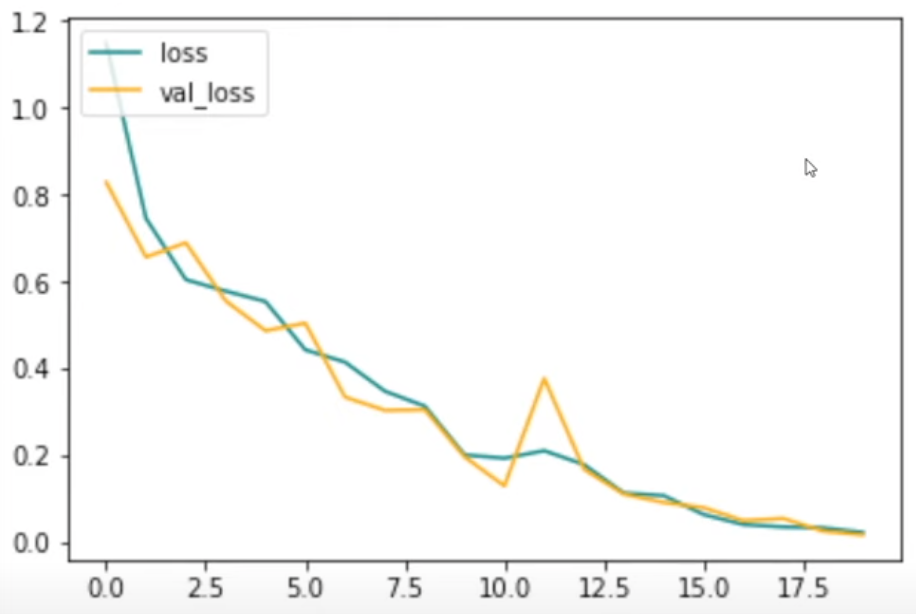

If the validation loss goes up while the training loss goes down, we are overfitting. 


We are also plotting the accuracy. It should look like this: 
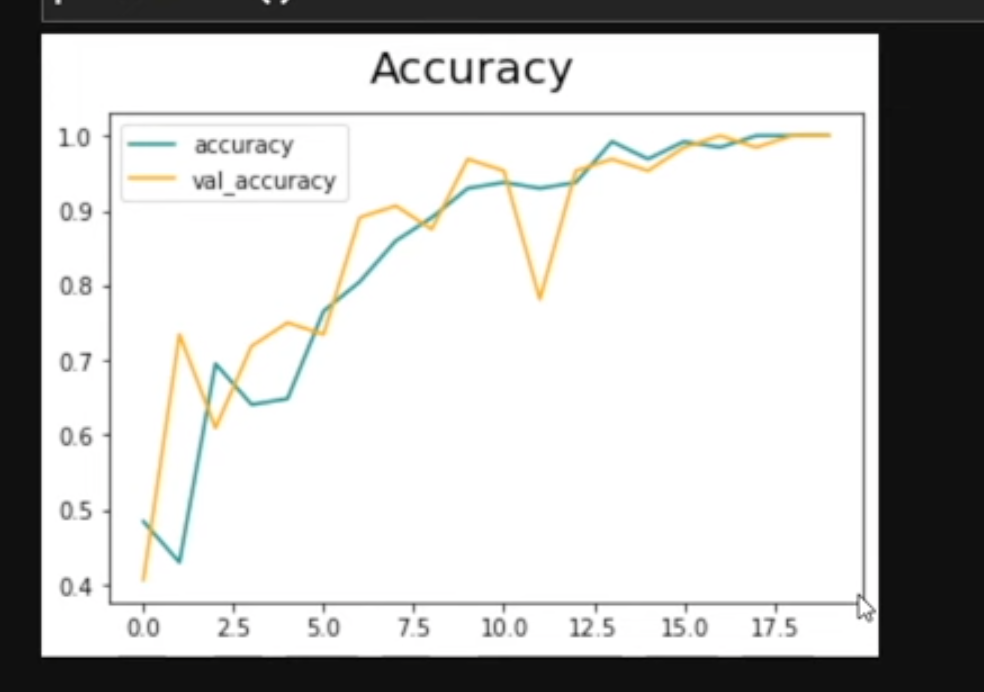

In [69]:
hist.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'mean_absolute_error', 'precision_2', 'recall_2', 'val_loss', 'val_categorical_accuracy', 'val_mean_absolute_error', 'val_precision_2', 'val_recall_2'])

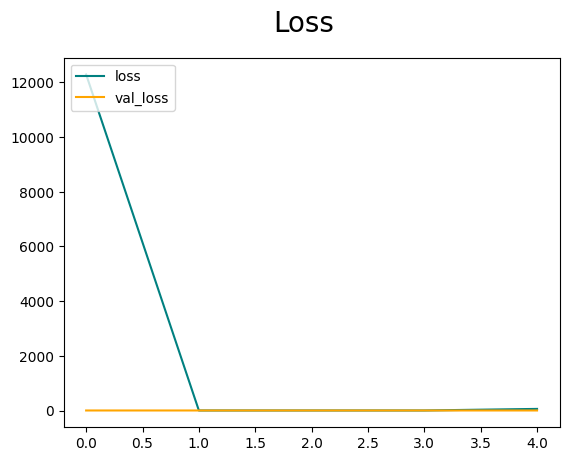

In [70]:
# Loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

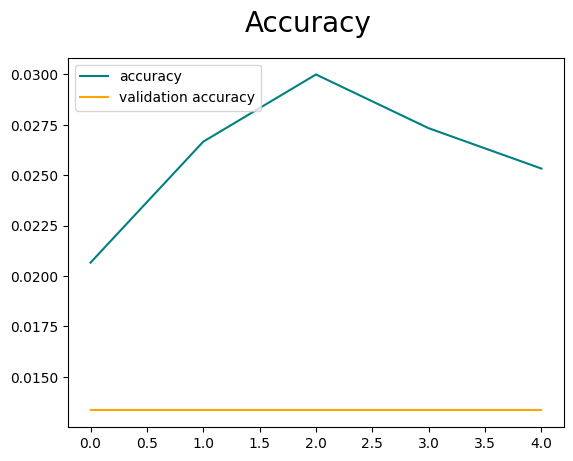

In [71]:
# Accuracy
fig = plt.figure()
plt.plot(hist.history['categorical_accuracy' ], color='teal', label='accuracy')
plt.plot(hist.history["val_categorical_accuracy" ], color='orange', label='validation accuracy')

fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

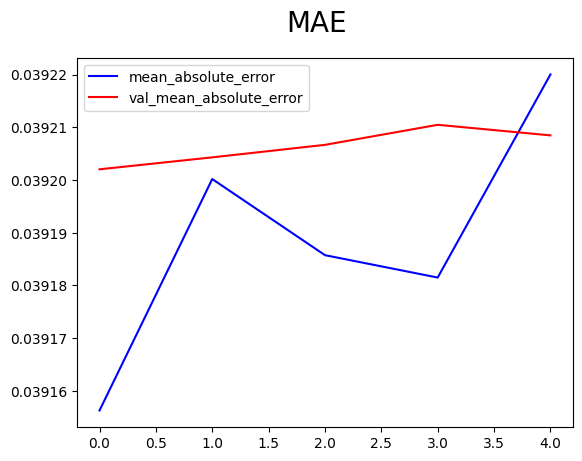

In [72]:
# Error
fig = plt.figure()
plt.plot(hist.history['mean_absolute_error'], color='blue', label='mean_absolute_error')

plt.plot(hist.history['val_mean_absolute_error'], color='red', label='val_mean_absolute_error')

fig.suptitle('MAE', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [73]:
metric_names = list(hist.history.keys())

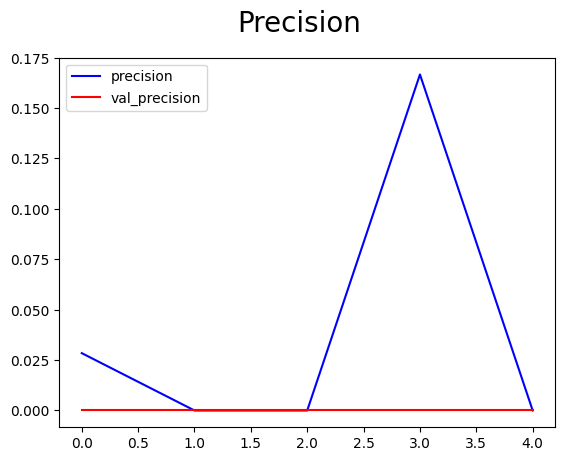

In [74]:
# Precision
fig = plt.figure()
p = [n for n in metric_names if n[:9]=='precision'][0]
vp = [n for n in metric_names if n[:9]=='val_preci'][0]
plt.plot(hist.history[p], color='blue', label='precision')
plt.plot(hist.history[vp], color='red', label='val_precision')

fig.suptitle('Precision', fontsize=20)
plt.legend(loc="upper left")
plt.show()

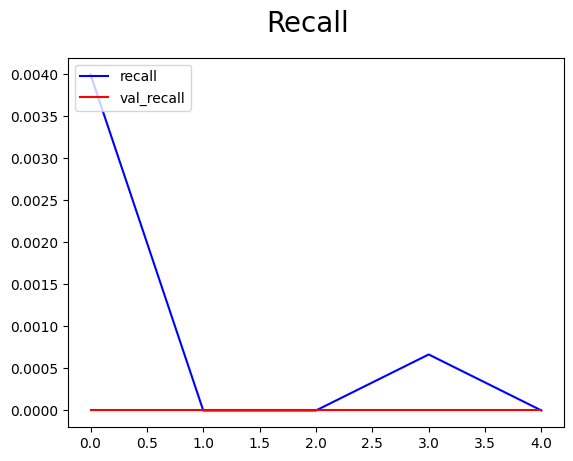

In [75]:
# Recall
fig = plt.figure()
r = [n for n in metric_names if n[:6]=='recall'][0]
vr = [n for n in metric_names if n[:6]=='val_re'][0]
plt.plot(hist.history[r], color='blue', label='recall')
plt.plot(hist.history[vr], color='red', label='val_recall')
fig.suptitle('Recall', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [76]:
# evaluation
pre = Precision()
re = Recall()
acc = CategoricalAccuracy() # I may need another type of accuracy here, 

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

1/1 [==============================] - 0s 15ms/step
Precision: 0.0, Recall: 0.0, Accuracy: 0.0
